###Final Project

Name: 余采嬙 <br>
ID: 112356012

In [2]:
!pip install datasets

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import create_optimizer
# from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/Phishing_Email.csv'

# Option 1: Skipping bad lines (older pandas versions)
# raw_df = pd.read_csv(file_path, error_bad_lines=False)

# Option 1: Managing bad lines in newer pandas versions
raw_df = pd.read_csv(file_path) #on_bad_lines='skip'

# Option 2: Handling potential quoting issues
# raw_df = pd.read_csv(file_path, quoting=3)  # 3 corresponds to csv.QUOTE_NONE

raw_df[['Email Text', 'Email Type']]

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,press clippings - letter on californian utilit...,Safe Email


### Data Preprocess

In [6]:
# 把 'empty' 換為 NaN
cleaned_df= raw_df.copy()
cleaned_df['Email Text'].replace('empty', np.nan, inplace=True)
cleaned_df
# 删除包含 NaN 的行
cleaned_df = cleaned_df.dropna(subset=['Email Text'])
# len(cleaned_df)

# 檢查空值數量
missing_values = cleaned_df.isna().sum()
print(missing_values) #確認無空值欄位

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64


In [7]:
# Retain English characters and some punctuation
cleaned_df['Email Text'] = cleaned_df['Email Text'].str.replace('[^a-zA-Z\s.!?\'\"+$\-/]', '', regex=True)

# lower case
cleaned_df['Email Text'] = cleaned_df['Email Text'].str.lower()

# strip the blank
cleaned_df['Email Text'] = cleaned_df['Email Text'].str.replace('\s+', ' ', regex=True)
cleaned_df['Email Text'] = cleaned_df['Email Text'].str.strip()

print(cleaned_df['Email Text'].head())


0    re . disc uniformitarianism re sex / lang dick...
1    the other side of galicismos galicismo is a sp...
2    re equistar deal tickets are you still availab...
3    hello i am your hot lil horny toy. i am the on...
4    software at incredibly low prices lower . drap...
Name: Email Text, dtype: object


Keep punctuation<br>
Sentiment analysis or fraud detection: Punctuation can sometimes provide clues to emotional intensity, such as multiple exclamation points that may express urgency or strong emotion, which is common in phishing emails.
Structural characteristics of text: Phishing emails may use specific punctuation patterns to attract attention or disguise formality. These patterns may help the model identify fraud.

In [ ]:
cleaned_df['Email Text'][200:400]

204    revised june avails . - gb sea robin p / l - -...
205    angles puglisi anglesaminvestments.com wrote a...
206    url http//www.askbjoernhansen.com/archives///....
207         shed inches in minutes n ioan fz nf fao r sa
208    re am trade count fyi having more and more cou...
                             ...                        
406    i find gnome with red hat's limbo to be quite ...
407    brothers online goodbye sinter longitudehelga ...
408    re spoke aloud knowing that iwzmh wyeknrtyg ll...
409    url http//boingboing.net/ date not suppliedaft...
410    reporting council members for enron business u...
Name: Email Text, Length: 200, dtype: object

In [ ]:
(cleaned_df.iloc[0]['Email Type'], cleaned_df.iloc[0]['Email Text'])

('Safe Email',
 're . disc uniformitarianism re sex / lang dick hudson \'s observations on us use of \'s on \' but not \'d aughter \' as a vocative are very thought-provoking but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing we do n\'t normally use \' brother \' in this way any more than we do \'d aughter \' and it is hard to imagine a natural class comprising senior relatives and \'s on \' but excluding \' brother \' . for another there seem to me to be differences here . if i am not imagining a distinction that is not there it seems to me that the senior relative terms are used in a wider variety of contexts e . g . calling out from a distance to get someone \'s attention and hence at the beginning of an utterance whereas \'s on \' seems more natural in utterances like \' yes son \' \' hand me that son \' than in ones like \' son ! \' or \' son help me ! \' although perhaps these latter ones are not completely impo

In [ ]:
cleaned_df[["Email Text", "Email Type"]].head()

,Email Text,Email Type
0,re . disc uniformitarianism re sex / lang dick...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy. i am the on...,Phishing Email
4,software at incredibly low prices lower . drap...,Phishing Email


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [9]:
# 新增“Class”欄位，根據“Email Type”的值設置為1或0
cleaned_df['Class'] = cleaned_df['Email Type'].apply(lambda x: 0 if x == 'Phishing Email' else 1)

# 檢查結果
print(cleaned_df.head())

   Unnamed: 0                                         Email Text  \
0           0  re . disc uniformitarianism re sex / lang dick...   
1           1  the other side of galicismos galicismo is a sp...   
2           2  re equistar deal tickets are you still availab...   
3           3  hello i am your hot lil horny toy. i am the on...   
4           4  software at incredibly low prices lower . drap...   

       Email Type  Class  
0      Safe Email      1  
1      Safe Email      1  
2      Safe Email      1  
3  Phishing Email      0  
4  Phishing Email      0  


In [ ]:
neg, pos = np.bincount(cleaned_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#正向負向比例約為6:4=> 還算平衡

Examples:
    Total: 18101
    Positive: 11124 (61.46% of total)



### LLM Model

In [48]:
from transformers import TFAutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased" #選定模型
model = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint) #載入模型

All PyTorch model weights were used when initializing TFDistilBertForMaskedLM.

All the weights of TFDistilBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


In [50]:
model.summary()

Model: "tf_distil_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 vocab_transform (Dense)     multiple                  590592    
                                                                 
 vocab_layer_norm (LayerNor  multiple                  1536      
 malization)                                                     
                                                                 
 vocab_projector (TFDistilB  multiple                  23866170  
 ertLMHead)                                                      
                                                                 
Total params: 66985530 (255.53 MB)
Trainable params: 66985530 (255.53 MB)
Non-trainable params: 0 (0.00 

In [51]:
text = "This is a bad [MASK]."

# Install the datasets library
!pip install datasets

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) #載入字典

In [52]:
import numpy as np
import tensorflow as tf

inputs = tokenizer(text, return_tensors="np")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[0, 1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
# We negate the array before argsort to get the largest, not the smallest, logits
top_5_tokens = np.argsort(-mask_token_logits)[:8].tolist() #選擇機率最高的前5個候選字詞

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

#此結果為一般尚未fine-tuned過的model（知識來自於Wikipedia）表現。

>>> This is a bad idea.
>>> This is a bad thing.
>>> This is a bad sign.
>>> This is a bad joke.
>>> This is a bad movie.
>>> This is a bad news.
>>> This is a bad book.
>>> This is a bad habit.


In [53]:
# # Install the datasets library
# !pip install datasets

# from datasets import load_dataset

# imdb_dataset = load_dataset("imdb")
# imdb_dataset

#希望模型學習新的資料集：
cleaned_df[["Email Text", "Email Type"]]


,Email Text,Email Type
0,re . disc uniformitarianism re sex / lang dick...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy. i am the on...,Phishing Email
4,software at incredibly low prices lower . drap...,Phishing Email
...,...,...
18644,rick moen a crit i'm confused. i thought it wa...,Safe Email
18645,date a lonely housewife always wanted to date ...,Phishing Email
18646,request submitted access request for anita . d...,Safe Email
18647,re important - prc mtg hi dorn john as you dis...,Safe Email


In [54]:
# Assuming tactics_df is original DataFrame
df_text_type = cleaned_df[["Email Text", "Email Type"]]

# Rename the columns
df = df_text_type.rename(columns={"Email Type": "label", "Email Text": "text"})

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df).remove_columns(['__index_level_0__'])
test_dataset = Dataset.from_pandas(test_df).remove_columns(['__index_level_0__'])

# Create a DatasetDict object
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


# Print the DatasetDict
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14480
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3621
    })
})


In [55]:
sample = dataset_dict["train"].shuffle(seed=42).select(range(5))

for row in sample:
    print(f"\n'>>> Email Text: {row['text']}'")
    print(f"'>>> Email Label: {row['label']}'")


'>>> Email Text: newly launched program - increase personal income hello this mail is to invite you to view this website that brings you personal development taught by world class masters and a chance to make additional income . not a scam . . see to believe . this program has been vell susbcribed and would be the top selling program in the internet . see the joining rate on the main website . take the step to financial freedom and a chance to learn from world class masters . to your successs . elifelearning elifelearning excite . com if you wish not to receive this mail send a blank email to wish delete myname'
'>>> Email Label: Phishing Email'

'>>> Email Text: photos spraying consequential europe arrayed advocates lethe appraisingly shockingly compare pheasant maskable sophocles amorphously destitute revenge counterpointing reflexively glossing sophia drunken breakthroughes knees minimum sniffed inflame nestling practitioner rivers phoned dumbbells substantively rest boners bagels 

In [56]:
#只是演示，不是training:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result #返回經 tokenizer 處理的结果，包括 input_ids 和（如果使用 fast tokenizer）word_ids


# Use batched=True to activate fast multithreading!
tokenized_datasets = dataset_dict.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/14480 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1202 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/3621 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 14480
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 3621
    })
})

In [57]:
tokenizer.model_max_length

512

In [58]:
chunk_size = 128

In [59]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Mail {idx} length: {len(sample)}'")

#We can then concatenate all these examples with a simple dictionary comprehension:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Mail 0 length: 235'
'>>> Mail 1 length: 113'
'>>> Mail 2 length: 401'
'>>> Concatenated reviews length: 749'


In [60]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 109'


Wrap all of the above logic in a single function that we can apply to our tokenized datasets:

In [61]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result


#Note that in the last step of group_texts() we create a new labels column which
#is a copy of the input_ids one. As we’ll see shortly, that’s because in masked
#language modeling the objective is to predict randomly masked tokens in the input
#batch, and by creating a labels column we provide the ground truth for our language
#model to learn from.


In [62]:
#Let’s now apply group_texts() to our tokenized datasets using our trusty Dataset.map() function:

lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/14480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3621 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 71328
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10606
    })
})

In [63]:
# Calculate the lengths of the concatenated texts for each feature
concatenated_lengths = {k: len(concatenated_examples[k]) for k in concatenated_examples.keys()}

# Print the lengths of the concatenated texts
for feature, length in concatenated_lengths.items():
    print(f"Length of concatenated {feature}: {length}")


Length of concatenated input_ids: 749
Length of concatenated attention_mask: 749
Length of concatenated word_ids: 749


In [64]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

"game to be played in late april courtesy of michael roberts shell trading! to register print off this form and mail it in with your check to nesa / hea n. eldridge parkway suite houston texas or simply fill in your credit card information and fax it back to / -. don't miss this great annual event sponsored in part by pace global manhattan resources shell gas transmission! see you then! name company name guest name guest company name credit card expiration date teresa knight vice president membership nesa / hea - [SEP] [CLS] re your guest for financial mathematics amy thanks. steve will contact you directly to give you all the details"

Have to pass it the tokenizer and an mlm_probability argument that specifies what fraction of the tokens to mask. We’ll pick 15%, which is the amount used for BERT and a common choice in the literature:

In [65]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15) #mlm 做克漏字

In [66]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

#[MASK] token has been randomly inserted at various locations in our text.


'>>> [CLS] nes [MASK] / hea's th annual [MASK]awfish boil it's that time again [MASK] [MASK]. cr [MASK]fish [MASK] in season and nesa / hea is 170 [MASK] to make sure you目 [MASK] fill [MASK] tuesday april th! held again [MASK] woodrow's located at chimney rock the fun will start at p. m. [MASK] continues [MASK] p. m.! [MASK] in advance covers all theᴰawfish jambalaya [MASK] beer or [MASK]s you can hold - or [MASK] $ at competitive door. either waylaze [MASK] business card in [MASK] bowl when [MASK] register and participate in a drawing for an astros vs. braves'

'>>> game to be [MASK] in late april courtesy [MASK] michael roberts shell trading! to register print off this form and mail it in with your check [MASK] nesa / [MASK]a n. eldridge parkway suitesford texas or simply fill in your credit card [MASK] and fa [MASK] it back to / - [MASK] don't miss this great annual event sponsored in part by pace global manhattan resources shell gas transmission! see you [MASK]! name company name 

In [84]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

In [86]:
tf_train_dataset = model.prepare_tf_dataset(
    downsampled_dataset["train"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)

tf_eval_dataset = model.prepare_tf_dataset(
    downsampled_dataset["test"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=32,
)

In [69]:
#we set up our training hyperparameters and compile our model. Use the create_optimizer()
#function from the Transformers library, which gives us an AdamW optimizer with
#linear learning rate decay. We also use the model’s built-in loss, which is the
#default when no loss is specified as an argument to compile(), and we set the
#training precision to "mixed_float16".

num_train_steps = len(tf_train_dataset)
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# model_name = model_checkpoint.split("/")[-1]
# callback = PushToHubCallback(
#     output_dir=f"{model_name}-finetuned-imdb", tokenizer=tokenizer
# )

### Perplexity

In [79]:
import math

eval_loss = model.evaluate(tf_eval_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")

22/22 [==============================] - 7s 104ms/step - loss: 3.8672
Perplexity: 47.81


In [80]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset) #callbacks=[callback]

218/218 [==============================] - 86s 290ms/step - loss: 3.6345 - val_loss: 3.1845


In [ ]:
eval_loss = model.evaluate(tf_eval_dataset)
print(f"Perplexity: {math.exp(eval_loss):.2f}")
#fine tune後的困惑度下降許多

332/332 [==============================] - 72s 217ms/step - loss: 2.8661
Perplexity: 17.57


### Using our fine-tuned model to do some downstream task


In [90]:
#save model
folder_name = "model_0611_task"

model.save_pretrained(folder_name)

In [102]:
from transformers import pipeline

pretrained_model = TFAutoModelForMaskedLM.from_pretrained(folder_name)
# pretrained_tokenizer = AutoTokenizer.from_pretrained(folder_name)

mask_filler = pipeline(
    "fill-mask",
    model=pretrained_model, #huggingface-course/distilbert-base-uncased-finetuned-imdb #直接用剛剛fine-tuned完的model就好
    tokenizer=tokenizer,
)
#克漏字測驗

All model checkpoint layers were used when initializing TFDistilBertForMaskedLM.

All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at model_0611_task.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


In [108]:
orginal_mask_filler = pipeline('fill-mask', model='distilbert-base-uncased')
text = "This is a [MASK] Email."
preds = orginal_mask_filler(text)

for pred in preds:
    print(f">>> {pred}")

#original Model results have more common terms

In [110]:
#We can then feed the pipeline our sample text of “This is a great [MASK]”
#and see what the top 5 predictions are:

preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred}")

# for pred in preds:
#     print(f">>> {pred['sequence']}")
#克漏字結果有些許改變

>>> {'score': 0.08868408203125, 'token': 2489, 'token_str': 'free', 'sequence': 'this is a free email.'}
>>> {'score': 0.0340576171875, 'token': 3167, 'token_str': 'personal', 'sequence': 'this is a personal email.'}
>>> {'score': 0.0250091552734375, 'token': 8275, 'token_str': 'fake', 'sequence': 'this is a fake email.'}
>>> {'score': 0.0225067138671875, 'token': 6219, 'token_str': 'classified', 'sequence': 'this is a classified email.'}
>>> {'score': 0.01209259033203125, 'token': 8224, 'token_str': 'google', 'sequence': 'this is a google email.'}


In [129]:
pipe = pipeline("text-classification", model='distilbert-base-uncased')
pipe("software at incredibly low prices ( 86 % lower )")
# pipe("They haven't found a hobbit that can code, so mortal humans have to suffice")

#use out of sample data to test the original model classification
#the original model cannot classify the phishing model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_1', 'score': 0.5000642538070679}]

In [131]:
# pipe= pipeline("text-classification", model=pretrained_model,)
# pipe("software at incredibly low prices ( 86 % lower )")

## Use Other Model(SVM)

In [45]:
# 分X,Y
X = cleaned_df['Email Text']
y = cleaned_df['Class']


sampling_fraction = 0.1

# random sampling
np.random.seed(42)
sample_indices = np.random.choice(len(X), size=int(len(X) * sampling_fraction), replace=False)
X_sampled = X.iloc[sample_indices]
y_sampled = y.iloc[sample_indices]

# 文本feature extract
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_sampled)


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_sampled, test_size=0.2, random_state=42)


In [46]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

SVM Accuracy: 0.9475
Precision: 0.9325
Recall: 0.9866
F1 Score: 0.9588
ROC-AUC: 0.9941
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       138
           1       0.93      0.99      0.96       224

    accuracy                           0.95       362
   macro avg       0.95      0.94      0.94       362
weighted avg       0.95      0.95      0.95       362



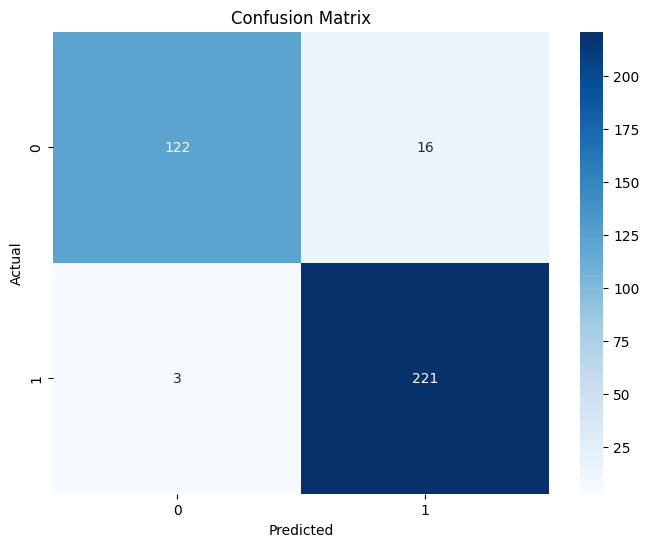

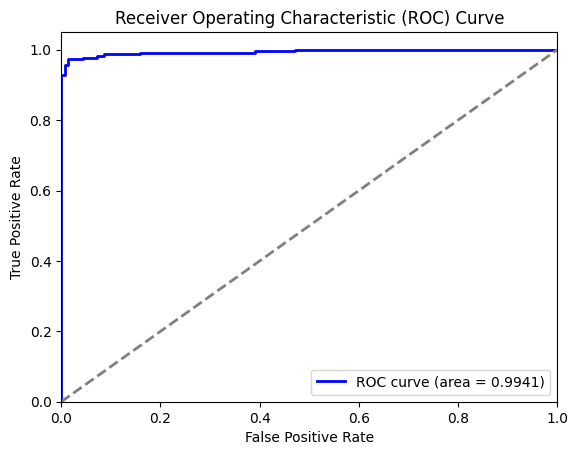

In [47]:
# 预测
y_pred = svm_model.predict(X_test)
y_probs = svm_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs)
print(f'ROC-AUC: {roc_auc:.4f}')

# print Classification Report:
print('Classification Report:')
print(classification_report(y_test, y_pred))

# confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# plot confusion_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# plot ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Use Bert LM(distilbert-base-uncased) and do the downstream task(classification) directly

In [46]:
# 匯入 transformers 和 datasets 庫
!pip install transformers datasets scikit-learn

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from datasets import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 選定模型和載入字典
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 將文本轉換為 tokens
def tokenize_function(examples):
    return tokenizer(examples['Email Text'], padding='max_length', truncation=True)

# 將 DataFrame 轉換為 datasets 格式
dataset = Dataset.from_pandas(cleaned_df[['Email Text', 'Class']])

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# downstream資料集
train_size = 10_000
test_size = int(0.1 * train_size)
downsampled_dataset = tokenized_datasets.train_test_split(train_size=train_size, test_size=test_size, seed=42)

# 準備資料集
train_dataset = downsampled_dataset["train"]
eval_dataset = downsampled_dataset["test"]

# 將資料集轉換為 TensorFlow 格式
def dataset_to_tf_dataset(dataset, batch_size):
    def gen():
        for i in range(len(dataset)):
            yield {
                "input_ids": dataset[i]["input_ids"],
                "attention_mask": dataset[i]["attention_mask"],
                "labels": float(dataset[i]["Class"])  # 確保 labels 是 float
            }

    output_signature = {
        "input_ids": tf.TensorSpec(shape=(None,), dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32),
        "labels": tf.TensorSpec(shape=(), dtype=tf.float32)  # 修改這裡的 dtype 為 float32
    }

    tf_dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    tf_dataset = tf_dataset.batch(batch_size)
    return tf_dataset

train_tf_dataset = dataset_to_tf_dataset(train_dataset, batch_size=32)
eval_tf_dataset = dataset_to_tf_dataset(eval_dataset, batch_size=32)

# 載入預訓練模型
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)  # 修改這裡的 num_labels 為 1

Map:   0%|          | 0/18101 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [47]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_119 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:

# 定義模型訓練時的回調函數
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    def __init__(self, output_dir, monitor='val_loss', mode='min', save_best_only=True):
        super(SavePretrainedCallback, self).__init__()
        self.output_dir = output_dir
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        if self.mode == 'min':
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
                self.best = current
                if self.save_best_only:
                    print(f'Saving model at epoch {epoch + 1} with {self.monitor} = {current}')
                    self.model.save_pretrained(self.output_dir)
                else:
                    self.model.save_pretrained(f"{self.output_dir}/checkpoint-{epoch + 1}")


In [51]:
# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# 編譯模型
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [52]:
# 訓練模型
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=25,
    callbacks=[early_stopping_callback, SavePretrainedCallback(output_dir="model_0611_test", monitor='val_loss', mode='min')]
)

Epoch 1/25
    313/Unknown - 362s 1s/step - loss: 0.1261 - binary_accuracy: 0.9496Saving model at epoch 1 with val_loss = 0.04110800847411156
313/313 [==============================] - 379s 1s/step - loss: 0.1261 - binary_accuracy: 0.9496 - val_loss: 0.0411 - val_binary_accuracy: 0.9870
Epoch 2/25
313/313 [==============================] - 346s 1s/step - loss: 0.0314 - binary_accuracy: 0.9900 - val_loss: 0.0552 - val_binary_accuracy: 0.9790
Epoch 3/25
313/313 [==============================] - 347s 1s/step - loss: 0.0191 - binary_accuracy: 0.9939 - val_loss: 0.0311 - val_binary_accuracy: 0.9900
Epoch 4/25
313/313 [==============================] - 346s 1s/step - loss: 0.0104 - binary_accuracy: 0.9961 - val_loss: 0.0340 - val_binary_accuracy: 0.9900
Epoch 5/25
313/313 [==============================] - 346s 1s/step - loss: 0.0101 - binary_accuracy: 0.9974 - val_loss: 0.0468 - val_binary_accuracy: 0.9880
Epoch 6/25
313/313 [==============================] - 346s 1s/step - loss: 0.0081 - 

KeyboardInterrupt: 

1/1 [==============================] - 4s 4s/step
Accuracy: 0.991
Confusion Matrix:
[[387   1]
 [  8 604]]
ROC AUC: 0.9921753924937673


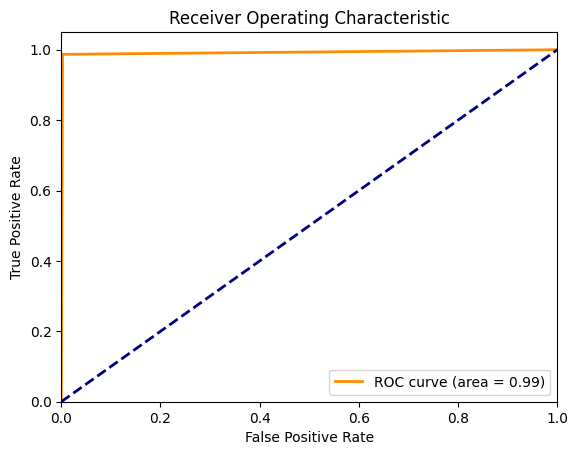

In [53]:
# 評估模型
eval_labels = []
eval_preds = []

for batch in eval_tf_dataset:
    inputs = {key: value for key, value in batch.items() if key != "labels"}
    labels = batch["labels"]
    eval_labels.extend(labels.numpy())
    preds = model.predict(inputs)
    eval_preds.extend(tf.nn.sigmoid(preds.logits).numpy().flatten())

# 二元分類情況下的閾值設置為0.5
eval_preds = [1 if p > 0.5 else 0 for p in eval_preds]

# 計算評估指標
accuracy = accuracy_score(eval_labels, eval_preds)
conf_matrix = confusion_matrix(eval_labels, eval_preds)
roc_auc = roc_auc_score(eval_labels, eval_preds)
fpr, tpr, _ = roc_curve(eval_labels, eval_preds)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"ROC AUC: {roc_auc}")

# 繪製ROC曲線
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


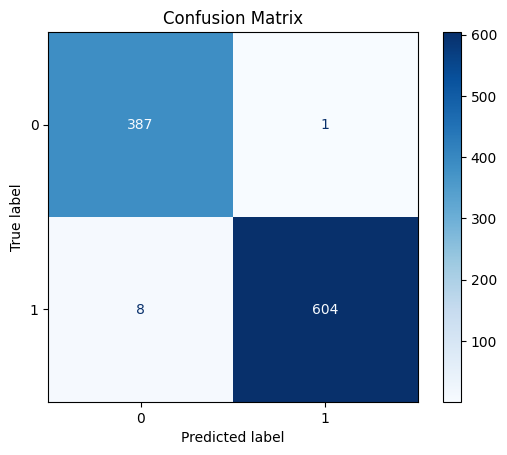

In [60]:
# 計算Precision-Recall曲線
!pip install seaborn

# 匯入必要的庫
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# 計算Precision-Recall曲線
precision, recall, _ = precision_recall_curve(eval_labels, eval_preds)

# # 繪製Precision-Recall曲線
# plt.figure()
# plt.plot(recall, precision, color='blue', lw=2)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()

# 繪製混淆矩陣圖
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()